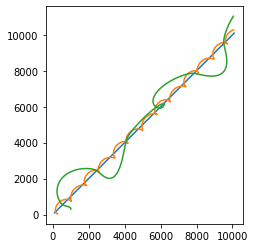

In [15]:
%matplotlib inline

from abc import ABC, abstractmethod
import numpy as np
from numpy import array as vec
import numpy.linalg
import matplotlib.pyplot as plt
import itertools

MODEL_G = 2  # гравитационная постоянная
COLLISION_DISTANCE = 5.0
COLLISION_COEFFICIENT = 50.0
MODEL_DELTA_T = 0.01
TIME_TO_MODEL = 100

# ABC это не алфавит, а AbstractBaseClass. Не даст создать экземпляр, пока не переопределишь все методы-заглушки
class Universe(ABC):
    """Невнятная вселенная, основа всех миров"""

    def __init__(self):
        self.bodies = []

    @abstractmethod
    def gravity_flow_dencity_per_1_1(self, dist):
        """
        Плотность потока гравитационного поля между двумя
        единичными массами на заданном расстоянии
        """
        ...

    def model_step(self):
        """Итерация решения задачи Коши. Конечно не присуща вселенной, но тут на своём месте"""
        for b1, b2 in itertools.product(self.bodies, self.bodies):
            if b1 != b2:
                b1.apply_force(b1.force_induced_by_other(b2))
        for b in self.bodies:
            b.advance()

    def add_body(self, body):
        self.bodies.append(body)


class MaterialPoint:
    """Материальная точка, движущаяся по двумерной плоскости"""
    
    def __init__(self, universe, mass, position, velocity):
        self.universe = universe
        self.mass = mass
        self.position = position
        self.velocity = velocity
        universe.add_body(self)

        self.ptrace = [self.position.copy()]
        self.vtrace = [self.velocity.copy()]
    
    def force_induced_by_other(self, other):
        """Сила, с которой другое тело действует на данное"""
        delta_p = other.position - self.position
        distance = numpy.linalg.norm(delta_p)  # Евклидова норма (по теореме Пифагора)
        force_direction = delta_p / distance
        force = force_direction * self.mass * other.mass *\
                self.universe.gravity_flow_dencity_per_1_1(distance)
        return force

    def advance(self):
        """Перемещаем тело, исходя из его скорости"""
        self.position += self.velocity * MODEL_DELTA_T
        self.ptrace.append(self.position.copy())
        self.vtrace.append(self.velocity.copy())

    def apply_force(self, force):
        """Изменяем скорость, исходя из силы, действующей на тело"""
        self.velocity += force * MODEL_DELTA_T / self.mass


class Universe2D(Universe):
    def __init__(self,
                 G,                  # гравитационная постоянная
                 k,                  # коэффициент при упругом соударении
                 collision_distance  # всё-таки это не точки
                 ):
        super().__init__()
        self.G = G
        self.k = k
        self.collision_distance = collision_distance

    def gravity_flow_dencity_per_1_1(self, dist):
        # будем считать, что отскакивают точки друг от друга резко,
        # но стараться не допускать этого

        if dist > self.collision_distance:
            # Ситуация с обычным потоком поля — просто притяжение
            return self.G / dist
        else:
            # Отталкивание при соударении (притяжение убираем).
            # К гравитации не относится, т.к. имеет скорее электростатическую
            # природу, так что это sort of hack.
            # Никаких конкретных законов не реализует, просто нечто отрицательное =)
            return -self.k / dist 

u = Universe2D(MODEL_G, COLLISION_COEFFICIENT, COLLISION_DISTANCE)
# u = Universe2D(MODEL_G, 20, 4)

bodies = [
    MaterialPoint(u, 50000., vec([  100.,   100.]), vec([ 100.,   100.])),
    MaterialPoint(u,     10., vec([270.,   50.]), vec([ 10., -50.])),
    MaterialPoint(u,     10., vec([  1000., 300.]), vec([15.,   50.]))
]
    
steps = int(TIME_TO_MODEL / MODEL_DELTA_T)
for stepn in range(steps):
    u.model_step()


plt.gca().set_aspect('equal')

for b in bodies:
    # Вот так понятно
    # t = b.ptrace
    # xs = [p[0] for p in t]
    # ys = [p[1] for p in t]
    # plt.plot(xs, ys)
    # А так — лихо. Кто объяснит? =)
    plt.plot(*tuple(map(list, zip(*b.ptrace))))

plt.show();
